In [1]:
import os
import polars as pl
import duckdb
import time
from tqdm import tqdm
import pandas as pd
from helpers import track_memory_and_time, plot_results

# Warmup

In [2]:
base_path = "leash-BELKA"

In [3]:
# Lazily read the parquet file and select the first 10 rows
pd_train_head = pl.scan_parquet(os.path.join(base_path, "train.parquet")).fetch(10)
pd_train_head.head()

C:\Users\predator\AppData\Local\Temp\ipykernel_6308\3310058084.py:2: DeprecationWarning: `LazyFrame.fetch` is deprecated. `LazyFrame.fetch` is deprecated; use `LazyFrame.collect` instead, in conjunction with a call to `head`.
  pd_train_head = pl.scan_parquet(os.path.join(base_path, "train.parquet")).fetch(10)


id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
i64,str,str,str,str,str,i64
0,"""C#CC[C@@H](CC(=O)O)NC(=O)OCC1c…","""C#CCOc1ccc(CN)cc1.Cl""","""Br.Br.NCC1CCCN1c1cccnn1""","""C#CCOc1ccc(CNc2nc(NCC3CCCN3c3c…","""BRD4""",0
1,"""C#CC[C@@H](CC(=O)O)NC(=O)OCC1c…","""C#CCOc1ccc(CN)cc1.Cl""","""Br.Br.NCC1CCCN1c1cccnn1""","""C#CCOc1ccc(CNc2nc(NCC3CCCN3c3c…","""HSA""",0
2,"""C#CC[C@@H](CC(=O)O)NC(=O)OCC1c…","""C#CCOc1ccc(CN)cc1.Cl""","""Br.Br.NCC1CCCN1c1cccnn1""","""C#CCOc1ccc(CNc2nc(NCC3CCCN3c3c…","""sEH""",0
3,"""C#CC[C@@H](CC(=O)O)NC(=O)OCC1c…","""C#CCOc1ccc(CN)cc1.Cl""","""Br.NCc1cccc(Br)n1""","""C#CCOc1ccc(CNc2nc(NCc3cccc(Br)…","""BRD4""",0
4,"""C#CC[C@@H](CC(=O)O)NC(=O)OCC1c…","""C#CCOc1ccc(CN)cc1.Cl""","""Br.NCc1cccc(Br)n1""","""C#CCOc1ccc(CNc2nc(NCc3cccc(Br)…","""HSA""",0


In [4]:
# Connect to DuckDB and read only the first 10 rows
con = duckdb.connect()
sql_stm = f"""
    SELECT * 
    FROM parquet_scan('{os.path.join(base_path, 'train.parquet')}')
    LIMIT 10
"""
pd_train_head = con.execute(sql_stm).df()
pd_train_head.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,0,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,BRD4,0
1,1,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,HSA,0
2,2,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,sEH,0
3,3,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,BRD4,0
4,4,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,HSA,0


# Benchmark 1: counting

In [3]:
# Function to benchmark Polar
def benchmark_polars(file_path):
    start_time = time.time()

    # Use lazy frame for efficient loading and filtering
    if "parquet" in file_path:
        lazy_df = pl.scan_parquet(file_path)
    else:
        lazy_df = pl.scan_csv(file_path)

    # Execute query where 'binds' equals 1
    total_count = lazy_df.filter(pl.col("binds") == 0).select(pl.len()).collect()[0, 0]

    elapsed_time = time.time() - start_time
    return elapsed_time, total_count


# Function to benchmark DuckDB
def benchmark_duckdb(file_path):
    start_time = time.time()

    con = duckdb.connect()

    # Query using DuckDB's lazy loading and efficient memory handling
    if "parquet" in file_path:
        result = con.execute(
            f"SELECT COUNT(*) FROM parquet_scan('{file_path}') WHERE binds=0"
        ).fetchone()
    else:
        result = con.execute(
            f"SELECT COUNT(*) FROM read_csv_auto('{file_path}') WHERE binds=0"
        ).fetchone()
    total_count = result[0]

    elapsed_time = time.time() - start_time
    return elapsed_time, total_count

## Polar on parquet

In [8]:
%%timeit -n 1 -r 3

# checking function
runtime, mem, result = track_memory_and_time(
    benchmark_polars, os.path.join(base_path, "train.parquet")
)
print("Time:", runtime)
print("RAM:", mem)
print("Number of records:", result)

Time: 0.787351131439209
RAM: 2489.546875
Number of records: 293656924
Time: 0.5063464641571045
RAM: 2541.671875
Number of records: 293656924
Time: 0.5054361820220947
RAM: 2532.09375
Number of records: 293656924
1.15 s ± 145 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


## Polar on csv

In [15]:
%%timeit -n 1 -r 1

# checking function
runtime, mem, result = track_memory_and_time(
    benchmark_polars, os.path.join(base_path, "train.csv")
)
print("Time:", runtime)
# Check if peak memory is greater than 1000 MB
if mem > 1000:
    print(f"Peak memory usage: {mem / 1024:.2f} GB")
else:
    print(f"Peak memory usage: {mem:.2f} MB")
print("Number of records:", result)

Time: 43.21847414970398
Peak memory usage: 24.14 GB
Number of records: 293656924
43.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## DuckDB on parquet

In [9]:
%%timeit -n 1 -r 3

# checking function
runtime, mem, result = track_memory_and_time(
    benchmark_duckdb, os.path.join(base_path, "train.parquet")
)
print("Time:", runtime)
print("RAM:", mem)
print("Number of records:", result)

Time: 0.16701269149780273
RAM: 2541.26171875
Number of records: 293656924
Time: 0.16711211204528809
RAM: 2542.02734375
Number of records: 293656924
Time: 0.19008612632751465
RAM: 2541.875
Number of records: 293656924
1.39 s ± 5.92 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


## DuckDB on CSV

In [14]:
%%timeit -n 1 -r 1

# checking function
runtime, mem, result = track_memory_and_time(
    benchmark_duckdb, os.path.join(base_path, "train.csv")
)
print("Time:", runtime)
# Check if peak memory is greater than 1000 MB
if mem > 1000:
    print(f"Peak memory usage: {mem / 1024:.2f} GB")
else:
    print(f"Peak memory usage: {mem:.2f} MB")
print("Number of records:", result)

Time: 40.373278856277466
Peak memory usage: 1.42 GB
Number of records: 293656924
41.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# Start benchmark

In [4]:
### Run the benchmarks multiple times and store results ###
def run_benchmarks(file_path, n_runs=5, is_polar=True):
    results = []
    for i in tqdm(range(n_runs)):
        if is_polar:
            # Run Polars benchmark
            runtime, mem, result = track_memory_and_time(benchmark_polars, file_path)

            # Store the times in a list for each run
            results.append(
                {
                    "Run": i + 1,
                    "Polars Time": runtime,
                    "Polars Memory (MB)": mem,
                }
            )
        else:
            # Run DuckDB benchmark
            runtime, mem, result = track_memory_and_time(benchmark_duckdb, file_path)

            # Store the times in a list for each run
            results.append(
                {
                    "Run": i + 1,
                    "DuckDB Time": runtime,
                    "DuckDB Memory (MB)": mem,
                }
            )

        # wait for release memory
        time.sleep(5)

    return results

## Parquet benchmark

In [5]:
# Run the benchmarks
results_pl = run_benchmarks(os.path.join(base_path, "train.parquet"), n_runs=50)

# Convert the results to a DataFrame
df_results_pl = pd.DataFrame(results_pl)

100%|██████████| 50/50 [05:02<00:00,  6.05s/it]


In [6]:
# Run the benchmarks
results_db = run_benchmarks(
    os.path.join(base_path, "train.parquet"), n_runs=50, is_polar=False
)

# Convert the results to a DataFrame
df_results_db = pd.DataFrame(results_db)

100%|██████████| 50/50 [05:20<00:00,  6.41s/it]


In [7]:
df_results = df_results_pl.merge(df_results_db, on="Run")
df_results.head()

,Run,Polars Time,Polars Memory (MB),DuckDB Time,DuckDB Memory (MB)
0,1,0.725571,2477.312500,0.168805,2708.359375
1,2,0.523895,2507.671875,0.171342,2709.128906
2,3,0.505207,2525.410156,0.168518,2709.171875
3,4,0.506694,2546.871094,0.175215,2710.105469
4,5,0.504707,2563.273438,0.170497,2709.925781


In [8]:
df_results.to_csv("stats/benchmark1_parquet.csv", index=False)

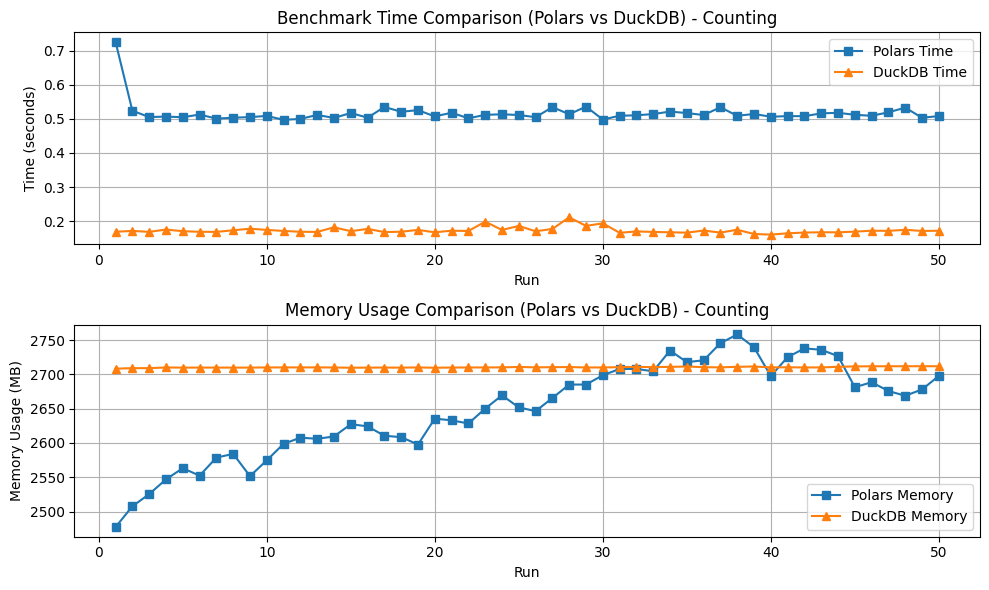

In [9]:
title1 = "Benchmark Time Comparison (Polars vs DuckDB) - Counting"
title2 = "Memory Usage Comparison (Polars vs DuckDB) - Counting"
plot_results(df_results, title1, title2)

## CSV benchmark

In [10]:
# Run the benchmarks
results_db = run_benchmarks(
    os.path.join(base_path, "train.csv"), n_runs=5, is_polar=False
)

# Convert the results to a DataFrame
df_results_db = pd.DataFrame(results_db)

100%|██████████| 5/5 [04:00<00:00, 48.10s/it]


In [11]:
# Run the benchmarks
results_pl = run_benchmarks(os.path.join(base_path, "train.csv"), n_runs=5)

# Convert the results to a DataFrame
df_results_pl = pd.DataFrame(results_pl)

100%|██████████| 5/5 [04:43<00:00, 56.72s/it]


In [12]:
df_results = df_results_pl.merge(df_results_db, on="Run")
df_results.head()

,Run,Polars Time,Polars Memory (MB),DuckDB Time,DuckDB Memory (MB)
0,1,33.697651,24286.570312,42.122135,3148.527344
1,2,53.738236,27145.773438,42.881872,3287.472656
2,3,56.419289,27004.015625,42.387825,3122.972656
3,4,56.272037,27013.207031,42.140444,3116.722656
4,5,55.046149,27050.335938,42.698847,3107.722656


In [13]:
df_results.to_csv("stats/benchmark1_csv.csv", index=False)

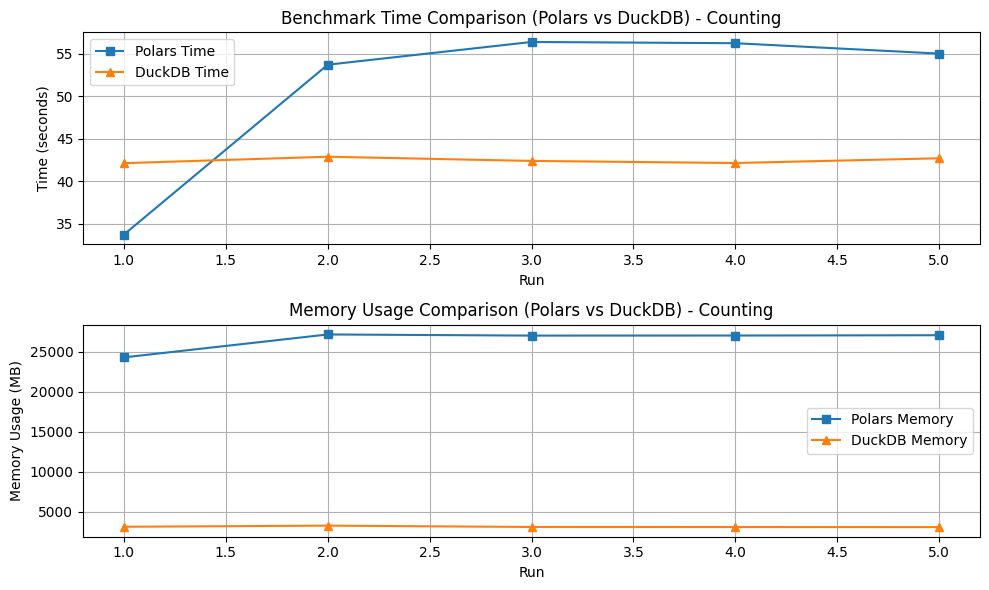

In [14]:
title1 = "Benchmark Time Comparison (Polars vs DuckDB) - Counting"
title2 = "Memory Usage Comparison (Polars vs DuckDB) - Counting"
plot_results(df_results, title1, title2)